## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-09 11:32:21--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  23.5MB/s    in 0.2s    

2025-03-09 11:32:21 (23.5 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [2]:
!pip install implicit optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.sparse import coo_array
from scipy.sparse import coo_matrix
from typing import Union
from sklearn.preprocessing import LabelEncoder
from scipy.sparse.linalg import svds
from numpy.linalg import svd
from implicit.als import AlternatingLeastSquares



import optuna
from optuna.samplers import TPESampler
RANDOM_STATE = 42
random_seed=42
sampler = TPESampler(seed = RANDOM_STATE) # Фиксируем случайность optun'ы

In [4]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [5]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [6]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [7]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [8]:
user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [9]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [10]:
def df_to_matrix(df: pd.DataFrame, rating_col) -> np.ndarray:

    user_ids = df['user_id'].unique()
    item_ids = df['item_id'].unique()

    result = np.zeros((len(user_ids), len(item_ids)), dtype=np.float64)

    for _, row in df.iterrows():
        user_index = row['user_id']
        item_index = row['item_id']
        result[user_index, item_index] = row[rating_col]

    return result #shape ~ [n_users, n_items]

In [11]:
interactions = df_to_matrix(df_train, 'rating')

In [12]:
interactions[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
def df_to_coo(df: pd.DataFrame, column_rating) -> coo_array:

    user_ids = df['user_id'].unique()
    item_ids = df['item_id'].unique()

    rows = []
    cols = []
    data = []

    for _, row in df.iterrows():
        user_index = row['user_id']
        item_index = row['item_id']
        rows.append(user_index)
        cols.append(item_index)
        data.append(row[column_rating])

    result = coo_array((data, (rows, cols)), shape=(len(user_ids), len(item_ids)))

    return result # coo_array

In [14]:
coo_interactions = df_to_coo(df_train, 'rating')

In [15]:
coo_interactions.toarray()[:10, :10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [16]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [17]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)


    if isinstance(interactions, np.ndarray):
        # Полная матрица
        U, S, V = svd(interactions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            V = V[:n_singular_values, :]

    elif isinstance(interactions, coo_array):
        # Разреженная матрица
        if n_singular_values == -1:
            n_singular_values = interactions.shape[1] - 1  # Все кроме одного
        U, S, V = svds(interactions, k=n_singular_values)

    if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            V = V[:n_singular_values, :]


    return U, np.diag(S), V

In [18]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [19]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [20]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    U, S, V = make_svd(interactions, n_singular_values)

    reconstr_matrix = U @ S @ V
    n_users, n_items = interactions.shape
    recommendations = np.zeros((n_users, top_k), dtype=int)

    for user in range(n_users):

        interacted_items = interactions[user].nonzero()[0]
        user_ratings = reconstr_matrix[user]
        user_ratings[interacted_items] = -np.inf  # Устанавливаем очень низкие значения для уже просмотренных

        # Получаем индексы топ_k самых высоких оценок
        top_k_ind = np.argsort(user_ratings)[-top_k:][::-1]
        recommendations[user] = top_k_ind


    return recommendations #shape ~ [n_users, top_k]

In [21]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

In [22]:
recs.shape

(5365, 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [23]:
def dcg(scores):
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )

def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_

# Напишем функцю, которая будет считать ndcg для каждого юзера.
def ndcg_score(df, test_interactions, predicted_recs):
    ndcg_list = 0
    for idx, row in df.iterrows():
        test = row[test_interactions]
        rec = row[predicted_recs]
        ndcg_list += ndcg_metric(test, rec)
    return ndcg_list/len(df)

# Объединяющая функция
def convert_to_col(joined_df, recs, name_of_new_col):
    df_to_join = pd.DataFrame(data={
        'user_id': range(len(recs)),
        name_of_new_col:[user_recs.tolist() for user_recs in recs]})
    new_joined_df = joined_df.merge(df_to_join, on='user_id', how='left')
    return new_joined_df

In [24]:
test_df_grouped = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
test_df_grouped.head()

,user_id,test_interactions
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]"
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]"
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4..."


Сделаем датафрейм из полученных ранее рекомендаций. В тесте всего 1147 юзеров, поэтому, чтобы посчитать ndcg объединим датафреймы при помощи left join.

In [25]:
test_df_grouped.shape, recs.shape

((1147, 2), (5365, 100))

In [26]:
test_df_grouped = convert_to_col(test_df_grouped, recs, 'svd_recs')
test_df_grouped.head()

,user_id,test_interactions,svd_recs
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124...","[1, 5, 2, 14, 20, 7, 12, 22, 28, 4, 27, 1542, ..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30...","[5, 32, 18, 19, 1046, 29, 31, 30, 20, 878, 224..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]","[10, 5, 1, 9, 23, 1610, 2241, 2237, 2607, 15, ..."
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]","[4, 2374, 28, 873, 215, 6, 24, 299, 1738, 2278..."
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4...","[6, 7, 2168, 2029, 2045, 2579, 725, 2278, 12, ..."


In [27]:
print(f"NDCG на тесте: {ndcg_score(test_df_grouped, 'test_interactions', 'svd_recs')}")

NDCG на тесте: 0.335721930672285


In [28]:
def plot_graphs(interractions: Union[np.ndarray, coo_array], test_df_grouped, top_k: int = 100):

    ndcg_scores = []
    times = []

    test_df_grouped_new = test_df_grouped.copy()

    for n_singular_values in [1, 10, 50, 200, 500, 700, 1000]:

        start_time = time.time()

        recommendations = make_svd_recommendations(interractions, n_singular_values=n_singular_values)
        test_df_grouped_new = convert_to_col(test_df_grouped_new, recommendations, f'svd_recs_{n_singular_values}')
        ndcg_scores.append(ndcg_score(test_df_grouped_new, "test_interactions", f'svd_recs_{n_singular_values}'))

        end_time = time.time()
        times.append(end_time - start_time)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot([1, 10, 50, 200, 500, 700, 1000], ndcg_scores, marker='o', color='red')
    plt.title('NDCG в зависимости от количества сингулярных чисел')
    plt.xlabel('Количество сингулярных чисел')
    plt.ylabel('NDCG')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot([1, 10, 50, 200, 500, 700, 1000], times, marker='o', color='blue')
    plt.title('Время вычисления')
    plt.xlabel('Количество сингулярных чисел')
    plt.ylabel('Время (в секундах)')
    plt.grid()

    plt.tight_layout()
    plt.show()

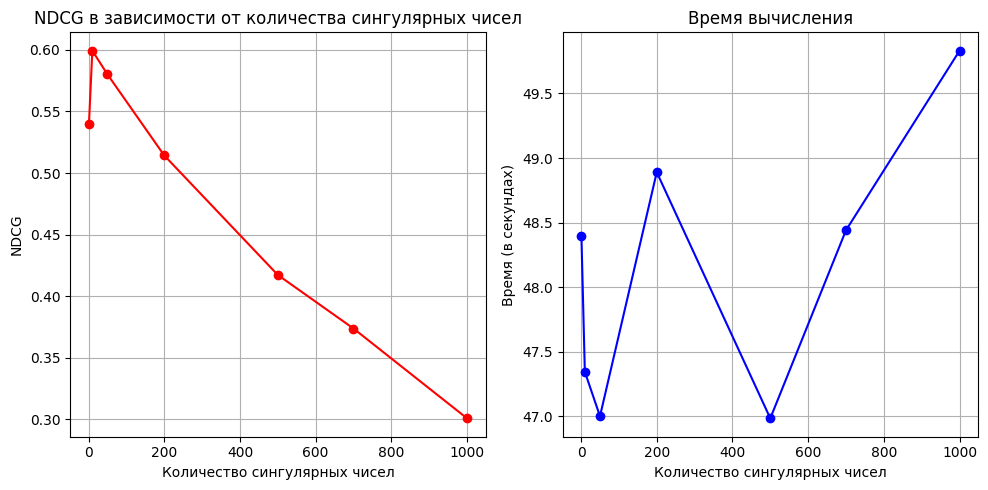

CPU times: user 8min 56s, sys: 41.7 s, total: 9min 38s
Wall time: 5min 37s


In [29]:
%%time
plot_graphs(interactions, test_df_grouped)

Интерпретируя полученные графики можно сделать вывод, что при увеличении количества сингулярных значений метрика ndcg сначала увеличивается, но сразу после достижения своего пика резко уменьшается. Это можно связать с переобучением, поскольку при слишком большом количестве сингулярных значений модель запоминает все шумы и специфические особенности данных, показывая хорошее качество на трейне, но плохое на тесте. Что касается времени работы алгоритма от числа сингулярных значений, то наблюдается странная картина: сначала при всего лишь одном сингулярном значении время выполнения задачи велико, но затем резкое падение и постепенное увеличение времени работы алгоритма при увеличении числа сингулярных значений, что может указывать на рост вычислительной сложности как при обучении модели, так и при её применении для генерации рекомендаций.

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [30]:
def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    #your code here

    user_ids, item_ids = interactions.nonzero()

    # Преобразуем разреженную матрицу в формат CSR
    csr_interactions = coo_matrix((interactions[user_ids, item_ids], (user_ids, item_ids)), shape=interactions.shape).tocsr()

    # Создаем и обучаем модель iALS
    model = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha)
    model.fit(csr_interactions)
    recommendations = model.recommend_all(csr_interactions, N=top_k)

    return model, recommendations #shape ~ [n_users, top_k]

In [31]:
best_model, recs = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

In [32]:
test_df_grouped = convert_to_col(test_df_grouped, recs, 'als_recs')
test_df_grouped.head()

,user_id,test_interactions,svd_recs,als_recs
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124...","[1, 5, 2, 14, 20, 7, 12, 22, 28, 4, 27, 1542, ...","[670, 665, 944, 580, 684, 925, 262, 924, 1417,..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30...","[5, 32, 18, 19, 1046, 29, 31, 30, 20, 878, 224...","[929, 944, 887, 2278, 904, 908, 685, 198, 812,..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]","[10, 5, 1, 9, 23, 1610, 2241, 2237, 2607, 15, ...","[215, 432, 2699, 399, 2588, 16, 948, 222, 95, ..."
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]","[4, 2374, 28, 873, 215, 6, 24, 299, 1738, 2278...","[877, 878, 2630, 885, 2806, 820, 968, 681, 103..."
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4...","[6, 7, 2168, 2029, 2045, 2579, 725, 2278, 12, ...","[889, 875, 496, 820, 1982, 1167, 1940, 877, 21..."


In [33]:
print(f"NDCG на тесте (ALS): {ndcg_score(test_df_grouped, 'test_interactions', 'als_recs')}")
print(f"NDCG на тесте (SVD): {ndcg_score(test_df_grouped, 'test_interactions', 'svd_recs')}")

NDCG на тесте (ALS): 0.5580237755072347
NDCG на тесте (SVD): 0.335721930672285


ALS показывает очень хорошее качество на метрике ndcg и превосходит SVD. Попробуем улучшить качество подобрав гиперпараметры.

In [34]:
%%time
def objective(trial, interactions):

    n_factors = trial.suggest_int('n_factors', 10, 200)
    alpha = trial.suggest_float('alpha', 0.1, 10)
    regularization = trial.suggest_float('regularization', 0.1, 10)

    _, recs = make_als_recommendations(interactions,
                                    n_factors=n_factors,
                                    alpha=alpha,
                                    regularization=regularization)

    test_df_grouped_optuna = test_df_grouped.copy()
    test_df_grouped_optuna = convert_to_col(test_df_grouped_optuna, recs, 'als_recs_optuna')
    ndsg_als = ndcg_score(test_df_grouped_optuna, 'test_interactions', 'als_recs_optuna')

    return ndsg_als


study_als = optuna.create_study(sampler=sampler, directions=['maximize'])
study_als.optimize(lambda trial: objective(trial, interactions), n_trials=50)

[I 2025-03-09 11:57:33,824] A new study created in memory with name: no-name-b3ba9993-df2e-4ba7-b618-0f2ef9db8fb2


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:57:45,056] Trial 0 finished with value: 0.5467546089596461 and parameters: {'n_factors': 81, 'alpha': 9.51207163345817, 'regularization': 7.34674002393291}. Best is trial 0 with value: 0.5467546089596461.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:57:58,933] Trial 1 finished with value: 0.548265786290766 and parameters: {'n_factors': 124, 'alpha': 1.6445845403801216, 'regularization': 1.6443457513284063}. Best is trial 1 with value: 0.548265786290766.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:58:08,647] Trial 2 finished with value: 0.5738779492849068 and parameters: {'n_factors': 21, 'alpha': 8.675143843171858, 'regularization': 6.051038616257767}. Best is trial 2 with value: 0.5738779492849068.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:58:21,438] Trial 3 finished with value: 0.5564690169135543 and parameters: {'n_factors': 145, 'alpha': 0.3037864935284442, 'regularization': 9.702107536403744}. Best is trial 2 with value: 0.5738779492849068.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:58:32,895] Trial 4 finished with value: 0.5274844522652185 and parameters: {'n_factors': 168, 'alpha': 2.202157195714934, 'regularization': 1.9000671753502962}. Best is trial 2 with value: 0.5738779492849068.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:58:41,622] Trial 5 finished with value: 0.5664599696024978 and parameters: {'n_factors': 45, 'alpha': 3.1119982052994235, 'regularization': 5.295088673159155}. Best is trial 2 with value: 0.5738779492849068.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:58:54,570] Trial 6 finished with value: 0.5492291246897733 and parameters: {'n_factors': 92, 'alpha': 2.983168487960615, 'regularization': 6.157343657751556}. Best is trial 2 with value: 0.5738779492849068.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:59:03,178] Trial 7 finished with value: 0.5761356148330457 and parameters: {'n_factors': 36, 'alpha': 2.99223202049866, 'regularization': 3.726982248607548}. Best is trial 7 with value: 0.5761356148330457.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:59:11,714] Trial 8 finished with value: 0.5504039025253152 and parameters: {'n_factors': 97, 'alpha': 7.873242017790835, 'regularization': 2.0767704433677614}. Best is trial 7 with value: 0.5761356148330457.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:59:22,092] Trial 9 finished with value: 0.541405645571004 and parameters: {'n_factors': 108, 'alpha': 5.96490423173422, 'regularization': 0.5598590859279775}. Best is trial 7 with value: 0.5761356148330457.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:59:32,616] Trial 10 finished with value: 0.563504337771512 and parameters: {'n_factors': 49, 'alpha': 4.785940482401218, 'regularization': 3.5995893690158716}. Best is trial 7 with value: 0.5761356148330457.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:59:39,573] Trial 11 finished with value: 0.5887029717185573 and parameters: {'n_factors': 11, 'alpha': 5.699569597745892, 'regularization': 3.939942181119708}. Best is trial 11 with value: 0.5887029717185573.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:59:45,548] Trial 12 finished with value: 0.5858607521688515 and parameters: {'n_factors': 12, 'alpha': 5.362335550515316, 'regularization': 3.7666540399843345}. Best is trial 11 with value: 0.5887029717185573.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:59:52,584] Trial 13 finished with value: 0.5892435780140812 and parameters: {'n_factors': 11, 'alpha': 6.280273414074072, 'regularization': 3.6253031110164367}. Best is trial 13 with value: 0.5892435780140812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 11:59:59,653] Trial 14 finished with value: 0.5523151186967445 and parameters: {'n_factors': 64, 'alpha': 7.125817087555807, 'regularization': 8.039402079999814}. Best is trial 13 with value: 0.5892435780140812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:00:15,279] Trial 15 finished with value: 0.5263882781548499 and parameters: {'n_factors': 188, 'alpha': 6.7097025097968395, 'regularization': 4.224168927189467}. Best is trial 13 with value: 0.5892435780140812.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:00:22,343] Trial 16 finished with value: 0.5979696977361025 and parameters: {'n_factors': 10, 'alpha': 4.193103198790526, 'regularization': 2.5713702677098773}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:00:31,087] Trial 17 finished with value: 0.5550239925399463 and parameters: {'n_factors': 70, 'alpha': 4.290556954718373, 'regularization': 2.43706441152491}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:00:41,912] Trial 18 finished with value: 0.5715564408225732 and parameters: {'n_factors': 31, 'alpha': 4.187354253190591, 'regularization': 0.18242227533675281}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:00:53,536] Trial 19 finished with value: 0.5544758096073329 and parameters: {'n_factors': 53, 'alpha': 6.967361949183713, 'regularization': 2.811824093028997}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:01:07,248] Trial 20 finished with value: 0.5348164736938138 and parameters: {'n_factors': 122, 'alpha': 8.231972493455393, 'regularization': 5.0192769644811746}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:01:14,438] Trial 21 finished with value: 0.5913366794552964 and parameters: {'n_factors': 12, 'alpha': 5.744808543657687, 'regularization': 4.667907910920187}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:01:25,243] Trial 22 finished with value: 0.5816160164249794 and parameters: {'n_factors': 28, 'alpha': 3.9626807402739033, 'regularization': 4.873532908018673}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:01:31,037] Trial 23 finished with value: 0.586883977381654 and parameters: {'n_factors': 10, 'alpha': 6.19351849955601, 'regularization': 1.0920401978146135}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:01:39,617] Trial 24 finished with value: 0.564591362879418 and parameters: {'n_factors': 37, 'alpha': 5.2862783019602375, 'regularization': 2.968035057066809}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:01:51,987] Trial 25 finished with value: 0.554381275410704 and parameters: {'n_factors': 60, 'alpha': 7.73411056759469, 'regularization': 6.347239047237215}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:02:00,939] Trial 26 finished with value: 0.581617514099057 and parameters: {'n_factors': 23, 'alpha': 4.734740325049761, 'regularization': 3.077933266826143}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:02:11,026] Trial 27 finished with value: 0.5528312103970031 and parameters: {'n_factors': 75, 'alpha': 6.27078182747124, 'regularization': 4.630057622121644}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:02:20,256] Trial 28 finished with value: 0.5720315797499619 and parameters: {'n_factors': 41, 'alpha': 3.5851599159477776, 'regularization': 1.0955934314764058}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:02:29,586] Trial 29 finished with value: 0.5713747433993502 and parameters: {'n_factors': 22, 'alpha': 8.799121705818418, 'regularization': 7.534872636524006}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:02:40,120] Trial 30 finished with value: 0.5602507980727255 and parameters: {'n_factors': 50, 'alpha': 9.518906530824424, 'regularization': 5.582683685592491}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:02:47,116] Trial 31 finished with value: 0.5963982344356996 and parameters: {'n_factors': 10, 'alpha': 5.134148243168219, 'regularization': 4.361475620745745}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:02:55,655] Trial 32 finished with value: 0.5826434165565288 and parameters: {'n_factors': 19, 'alpha': 4.914047122638045, 'regularization': 4.417388352365572}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:03:02,748] Trial 33 finished with value: 0.5773217175416683 and parameters: {'n_factors': 32, 'alpha': 2.1385984399453455, 'regularization': 3.2037555515095018}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:03:08,960] Trial 34 finished with value: 0.5938654373551362 and parameters: {'n_factors': 11, 'alpha': 6.5153179914918455, 'regularization': 2.453200177844865}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:03:23,030] Trial 35 finished with value: 0.5352996439901714 and parameters: {'n_factors': 151, 'alpha': 5.597009458979213, 'regularization': 6.8213407971993725}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:03:32,308] Trial 36 finished with value: 0.5838601372555317 and parameters: {'n_factors': 23, 'alpha': 0.9927231241795331, 'regularization': 1.4198154155544427}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:03:44,008] Trial 37 finished with value: 0.5531916761366502 and parameters: {'n_factors': 83, 'alpha': 3.761359919088952, 'regularization': 2.218178582424427}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:03:53,214] Trial 38 finished with value: 0.5674032389546823 and parameters: {'n_factors': 41, 'alpha': 7.407868767377906, 'regularization': 5.593113458569329}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:04:02,007] Trial 39 finished with value: 0.5796528315841621 and parameters: {'n_factors': 19, 'alpha': 6.598790447125474, 'regularization': 8.695447342039072}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:04:09,417] Trial 40 finished with value: 0.5762924584840886 and parameters: {'n_factors': 34, 'alpha': 3.3333438312915034, 'regularization': 1.6885425774670448}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:04:15,729] Trial 41 finished with value: 0.5957290490668132 and parameters: {'n_factors': 10, 'alpha': 4.426025663004943, 'regularization': 3.473121620866973}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:04:24,287] Trial 42 finished with value: 0.5838733789734859 and parameters: {'n_factors': 18, 'alpha': 4.50070382566403, 'regularization': 2.5613164483853788}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:04:35,225] Trial 43 finished with value: 0.5762683432809613 and parameters: {'n_factors': 28, 'alpha': 2.795196320223602, 'regularization': 3.21504603872366}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:04:41,283] Trial 44 finished with value: 0.5883794783416528 and parameters: {'n_factors': 11, 'alpha': 5.828088312200324, 'regularization': 4.439000325151508}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:04:53,070] Trial 45 finished with value: 0.5573759621810384 and parameters: {'n_factors': 58, 'alpha': 5.172438481556063, 'regularization': 1.9310491581408677}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:05:03,153] Trial 46 finished with value: 0.5665796979996723 and parameters: {'n_factors': 46, 'alpha': 2.4301285784956823, 'regularization': 4.024086646554397}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:05:15,708] Trial 47 finished with value: 0.5233721087329593 and parameters: {'n_factors': 198, 'alpha': 4.475719005948264, 'regularization': 3.485067544629196}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:05:24,967] Trial 48 finished with value: 0.574158134539019 and parameters: {'n_factors': 18, 'alpha': 9.974951301961635, 'regularization': 5.221116629018949}. Best is trial 16 with value: 0.5979696977361025.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-09 12:05:30,759] Trial 49 finished with value: 0.5938834090303873 and parameters: {'n_factors': 10, 'alpha': 5.4046290523048715, 'regularization': 5.686161504156201}. Best is trial 16 with value: 0.5979696977361025.


CPU times: user 11min 39s, sys: 1min 44s, total: 13min 23s
Wall time: 7min 56s


In [35]:
study_als.trials_dataframe().query(f'value > {0.59}').sort_values('value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_n_factors,params_regularization,state
16,16,0.597970,2025-03-09 12:00:15.280404,2025-03-09 12:00:22.343547,0 days 00:00:07.063143,4.193103,10,2.571370,COMPLETE
31,31,0.596398,2025-03-09 12:02:40.121063,2025-03-09 12:02:47.116202,0 days 00:00:06.995139,5.134148,10,4.361476,COMPLETE
41,41,0.595729,2025-03-09 12:04:09.418282,2025-03-09 12:04:15.729613,0 days 00:00:06.311331,4.426026,10,3.473122,COMPLETE
49,49,0.593883,2025-03-09 12:05:24.968564,2025-03-09 12:05:30.758918,0 days 00:00:05.790354,5.404629,10,5.686162,COMPLETE
34,34,0.593865,2025-03-09 12:03:02.749945,2025-03-09 12:03:08.960604,0 days 00:00:06.210659,6.515318,11,2.453200,COMPLETE
21,21,0.591337,2025-03-09 12:01:07.249209,2025-03-09 12:01:14.438676,0 days 00:00:07.189467,5.744809,12,4.667908,COMPLETE


In [36]:
study_als.trials_dataframe().query(f'value > {0.55}').sort_values('value', ascending=False).iloc[0, 5:-1]

,16
params_alpha,4.193103
params_n_factors,10
params_regularization,2.57137


In [37]:
best_params_als = study_als.best_params

print('Лучшие гиперпараметры: ', best_params_als)
print('Лучший ndcg: ', study_als.best_value)

Лучшие гиперпараметры:  {'n_factors': 10, 'alpha': 4.193103198790526, 'regularization': 2.5713702677098773}
Лучший ndcg:  0.5979696977361025


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

Перед тем, как объяснить рекомендации для нескольких юзеров, обучим модель с наилучшими найденными гиперпараметрами.

In [38]:
best_als_model, recs = make_als_recommendations(interactions,
                                    n_factors=best_params_als['n_factors'],
                                    alpha=best_params_als['alpha'],
                                    regularization=best_params_als['regularization'])

test_df_grouped = convert_to_col(test_df_grouped, recs, 'best_als_recs')
test_df_grouped.head()

  0%|          | 0/15 [00:00<?, ?it/s]

,user_id,test_interactions,svd_recs,als_recs,best_als_recs
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124...","[1, 5, 2, 14, 20, 7, 12, 22, 28, 4, 27, 1542, ...","[670, 665, 944, 580, 684, 925, 262, 924, 1417,...","[670, 961, 925, 684, 1617, 944, 1203, 665, 124..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30...","[5, 32, 18, 19, 1046, 29, 31, 30, 20, 878, 224...","[929, 944, 887, 2278, 904, 908, 685, 198, 812,...","[638, 670, 900, 929, 95, 908, 211, 94, 936, 88..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]","[10, 5, 1, 9, 23, 1610, 2241, 2237, 2607, 15, ...","[215, 432, 2699, 399, 2588, 16, 948, 222, 95, ...","[2211, 1735, 16, 215, 2030, 2035, 2283, 1793, ..."
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]","[4, 2374, 28, 873, 215, 6, 24, 299, 1738, 2278...","[877, 878, 2630, 885, 2806, 820, 968, 681, 103...","[877, 638, 876, 1203, 820, 1982, 449, 510, 104..."
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4...","[6, 7, 2168, 2029, 2045, 2579, 725, 2278, 12, ...","[889, 875, 496, 820, 1982, 1167, 1940, 877, 21...","[2168, 889, 1497, 94, 875, 877, 638, 499, 449,..."


In [39]:
print(f"NDCG на тесте (ALS):        {ndcg_score(test_df_grouped, 'test_interactions', 'als_recs')}")
print(f"NDCG на тесте (best ALS):   {ndcg_score(test_df_grouped, 'test_interactions', 'best_als_recs')}")
print(f"NDCG на тесте (SVD):        {ndcg_score(test_df_grouped, 'test_interactions', 'svd_recs')}")

NDCG на тесте (ALS):        0.5580237755072347
NDCG на тесте (best ALS):   0.5979172583801169
NDCG на тесте (SVD):        0.335721930672285


In [40]:
movies_df = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', encoding='latin-1', names=['item_id', 'movie_name', 'movie_genre'])
movies_df.head(20)

,item_id,movie_name,movie_genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [41]:
print(df.item_id.min(), df.item_id.max())
print(movies_df.item_id.min(), movies_df.item_id.max())

1 3952
1 3952


Никакого сдвига в индексах нет.

In [42]:
movies_df['movie_genre'].value_counts()[:5] # топ-5 жанров в датасете с фильмами

,count
movie_genre,
Drama,843
Comedy,521
Horror,178
Comedy|Drama,162
Comedy|Romance,142


Зафиксируем 3 случайно выбранных юзеров с индексами 911, 578 и 371.

In [43]:
# np.random.randint(0, test_df_grouped_als_new.shape[0], 3)
# array([911, 578, 371])

Посмотрим первого юзера.

In [44]:
user_items_911 = coo_matrix(interactions[911, :]).tocsr()
best_model.explain(0, user_items_911, 0)[:2]

(-0.21833484337686002,
 [(1793, 0.1401674769472241),
  (820, 0.03381632350252764),
  (982, 0.03266720421146534),
  (2248, 0.025652323677226925),
  (2417, 0.017503711912359117),
  (2029, 0.01573126015252096),
  (2269, 0.010201309066195154),
  (2980, 0.009846592231123916),
  (2147, 0.009824762525803662),
  (2210, 0.006416462425770358)])

In [45]:
first_user = [film[0] for film in best_model.explain(0, user_items_911, 0)[1]]
movies_df.loc[first_user, ['movie_name', 'movie_genre']]

,movie_name,movie_genre
1793,Species II (1998),Horror|Sci-Fi
820,Stonewall (1995),Drama
982,Big Night (1996),Drama
2248,"Alarmist, The (1997)",Comedy
2417,24-hour Woman (1998),Drama
2029,Son of Flubber (1963),Children's|Comedy
2269,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller
2980,How I Won the War (1967),Comedy|War
2147,"Skin Game, The (1931)",Drama
2210,Urban Legend (1998),Horror|Thriller


In [46]:
movies_for_911 = test_df_grouped['best_als_recs'].iloc[911][0]
movies_df.loc[movies_for_911, ['movie_name', 'movie_genre']]

,1137
movie_name,Raw Deal (1948)
movie_genre,Film-Noir


Рассмотриим какие фильмы оказали влияние на рекомендации к фильма Raw Deal (1948). Для юзера 911 видно, что фильмы, которые ему попали в рекомендации - в основном фильмы жанра Drama/Comedy. Фильмы в рекомендациях примерно одного времени (большинство 1994-1998). По жанру рекомендации средние, жанр комедия явно не соответсвует жанру Film-Noir.

Посмотрим второго юзера.

In [73]:
user_items_578 = coo_matrix(interactions[578, :]).tocsr()
best_model.explain(0, user_items_578, 3)[:2]

(0.1253691296746244,
 [(869, 0.02420926028651148),
  (672, 0.021034335260945232),
  (2418, 0.020925093730268744),
  (1318, 0.014666646282680102),
  (16, 0.0139159675911639),
  (936, 0.012127789750390123),
  (2183, 0.011789182226662944),
  (2971, 0.011445374078683176),
  (156, 0.011425332681611746),
  (2985, 0.011410055151272963)])

In [71]:
second_user = [film[0] for film in best_model.explain(0, user_items_578, 3)[1]]
movies_df.loc[second_user, ['movie_name', 'movie_genre']]

,movie_name,movie_genre
869,"Island of Dr. Moreau, The (1996)",Sci-Fi|Thriller
672,"Run of the Country, The (1995)",Drama
2418,"Blood, Guts, Bullets and Octane (1998)",Action|Comedy
1318,Bram Stoker's Dracula (1992),Horror|Romance
16,Sense and Sensibility (1995),Drama|Romance
936,Giant (1956),Drama
2183,Hero (1992),Comedy|Drama
2971,Meatballs (1979),Comedy
156,Casper (1995),Adventure|Children's
2985,Pokémon: The First Movie (1998),Animation|Children's


In [72]:
movies_for_578 = test_df_grouped['best_als_recs'].iloc[578][3]
movies_df.loc[movies_for_578, ['movie_name', 'movie_genre']]

,944
movie_name,Penny Serenade (1941)
movie_genre,Drama|Romance


Для юзера 578 рассмотрим 3 рекомендацию: фильм Penny Serenade (1941) в жанре Drama|Romance. На выбор алгоритмом этого фильма повлияли фильмы Run of the Country, The (1995), Bram Stoker's Dracula (1992), Sense and Sensibility (1995), Giant (1956), Hero (1992) с таким же жанром. То есть в данном случае мы угадали. Рекомендация адекватная, так как в основном пользователь смотрит такого рода фильмы.

Посмотрим рекомендацию для третьего пользователя.

In [86]:
user_items_371 = coo_matrix(interactions[371, :]).tocsr()
best_model.explain(0, user_items_371, 5)[:2]

(-0.16510232979786157,
 [(892, 0.07268795111373767),
  (381, 0.05361958197872771),
  (2346, 0.04005613625593798),
  (2844, 0.02605092748302913),
  (2438, 0.02545774192713526),
  (638, 0.02203383329439956),
  (869, 0.020691695842977104),
  (2838, 0.018392228324545096),
  (672, 0.017484495517443594),
  (2294, 0.016559384369817902)])

In [84]:
second_user = [film[0] for film in best_model.explain(0, user_items_578, 5)[1]]
movies_df.loc[second_user, ['movie_name', 'movie_genre']]

,movie_name,movie_genre
1386,Michael (1996),Comedy|Romance
1788,"Real Blonde, The (1997)",Comedy
812,"Collectionneuse, La (1967)",Drama
1823,"Perfect Murder, A (1998)",Mystery|Thriller
2364,"Civil Action, A (1998)",Drama
47,Pocahontas (1995),Animation|Children's|Musical|Romance
892,Rear Window (1954),Mystery|Thriller
62,Don't Be a Menace to South Central While Drink...,Comedy
2420,Spanish Fly (1998),Drama
1128,"Line King: Al Hirschfeld, The (1996)",Documentary


In [85]:
movies_for_371 = test_df_grouped['best_als_recs'].iloc[371][5]
movies_df.loc[movies_for_371, ['movie_name', 'movie_genre']]

,1383
movie_name,"Cérémonie, La (1995)"
movie_genre,Drama


Для данного пользователя рассмотрим какие фильмы повлияли на 5 рекомендацию. Рекомендованный фильм - Cérémonie, La (1995) (Drama). Фильмы, которые повлияли на рекомендацию: Collectionneuse, La (1967),	Civil Action, A (1998), Spanish Fly (1998) того же жанра, а также другие. Можно отметить, что рекомендованный фильм на французском языке, а в истории интеракций с другими фильмами видно, что тоже есть французские фильмы. Можно сказать, что рекомендация правильная и релевантна пользователю.

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

В предсказаниях для SVD будем брать n_singular_values=10, так как ранее узнали, что это оптимальное число сингулярных значений.

In [87]:
new_test_df = test_df_grouped[['user_id', 'test_interactions']].copy()

1.Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)

In [88]:
df_train['rating_1'] = np.where(df_train['rating'] > 0, 1, 0)

interactions_rating_1 = df_to_matrix(df_train, 'rating_1')
svd_recs_1 = make_svd_recommendations(interactions_rating_1, n_singular_values=10)
_, best_als_recs_1 = make_als_recommendations(interactions = interactions_rating_1, **best_params_als)

new_test_df = convert_to_col(new_test_df, best_als_recs_1, 'als_rating_1')
new_test_df = convert_to_col(new_test_df, svd_recs_1, 'svd_rating_1')

  0%|          | 0/15 [00:00<?, ?it/s]

In [89]:
print(f"NDCG на тесте (ALS):    {ndcg_score(new_test_df, 'test_interactions', 'als_rating_1')}")
print(f"NDCG на тесте (SVD):    {ndcg_score(new_test_df, 'test_interactions', 'svd_rating_1')}")

NDCG на тесте (ALS):    0.5930106801123655
NDCG на тесте (SVD):    0.5993511113914566


2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0.

In [90]:
df_train['rating_2'] = np.where(df_train['rating'] >=4, 1, 0)

interactions_rating_2 = df_to_matrix(df_train, 'rating_2')
svd_recs_2 = make_svd_recommendations(interactions_rating_2, n_singular_values=10)
_, best_als_recs_2 = make_als_recommendations(interactions = interactions_rating_2, **best_params_als)

new_test_df = convert_to_col(new_test_df, best_als_recs_2, 'als_rating_2')
new_test_df = convert_to_col(new_test_df, svd_recs_2, 'svd_rating_2')

  0%|          | 0/15 [00:00<?, ?it/s]

In [91]:
print(f"NDCG на тесте (ALS):    {ndcg_score(new_test_df, 'test_interactions', 'als_rating_2')}")
print(f"NDCG на тесте (SVD):    {ndcg_score(new_test_df, 'test_interactions', 'svd_rating_2')}")

NDCG на тесте (ALS):    0.5683621864846683
NDCG на тесте (SVD):    0.5993511113914566


3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1.

In [92]:
df_train['rating_3'] = np.where(df_train['rating'] >=4, 1, -1)

interactions_rating_3 = df_to_matrix(df_train, 'rating_3')
svd_recs_3 = make_svd_recommendations(interactions_rating_3, n_singular_values=10)
_, best_als_recs_3 = make_als_recommendations(interactions = interactions_rating_3, **best_params_als)

new_test_df = convert_to_col(new_test_df, best_als_recs_3, 'als_rating_3')
new_test_df = convert_to_col(new_test_df, svd_recs_3, 'svd_rating_3')

  0%|          | 0/15 [00:00<?, ?it/s]

In [93]:
print(f"NDCG на тесте (ALS):    {ndcg_score(new_test_df, 'test_interactions', 'als_rating_3')}")
print(f"NDCG на тесте (SVD):    {ndcg_score(new_test_df, 'test_interactions', 'svd_rating_3')}")

NDCG на тесте (ALS):    0.6102712412294787
NDCG на тесте (SVD):    0.5993511113914566


4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы

In [94]:
df_train['rating_4'] = np.where(df_train['rating'] >= 4, 1, -1)
max_date = df_train['datetime'].max()
df_train['day_diff'] = (max_date - df_train['datetime']).dt.days
smoothing_param = 0.95
df_train['weighted_time'] = smoothing_param ** (df_train['day_diff'] // 30)
df_train['rating_4'] = df_train['rating_4'] * df_train['weighted_time']

In [95]:
interactions_rating_4 = df_to_matrix(df_train, 'rating_4')
svd_recs_4 = make_svd_recommendations(interactions_rating_4, n_singular_values=10)
_, best_als_recs_4 = make_als_recommendations(interactions = interactions_rating_4, **best_params_als)

new_test_df = convert_to_col(new_test_df, best_als_recs_4, 'als_rating_4')
new_test_df = convert_to_col(new_test_df, svd_recs_4, 'svd_rating_4')

  0%|          | 0/15 [00:00<?, ?it/s]

In [96]:
print(f"NDCG на тесте (ALS):    {ndcg_score(new_test_df, 'test_interactions', 'als_rating_4')}")
print(f"NDCG на тесте (SVD):    {ndcg_score(new_test_df, 'test_interactions', 'svd_rating_4')}")

NDCG на тесте (ALS):    0.6115130321075333
NDCG на тесте (SVD):    0.5993511113914566


Учитывать сглаживание по времени оказалось отличной идеей! Наблюдается существенный рост метрики ndcg для ALS. SVD, показывает чуть худший результат и при этом долго работает. Также стратегия замены на 1/-1, если рейтинг>=4 в третьем пункте, показывает тоже хорошие результаты.

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [97]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):

        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):

        n_users = interactions.shape[0]
        n_items = interactions.shape[1]

        self.user_factors = np.random.randn(n_users, self.n_factors)
        self.item_factors = np.random.randn(n_items, self.n_factors)


        # Основной цикл обучения
        for iteration in range(n_iterations):
            # Обновляем матрицы факторов пользователей
            for u in range(n_users):
                item_indices = np.where(interactions[u] > 0)[0]
                if len(item_indices) > 0:
                    item_matrix = self.item_factors[item_indices]
                    ratings = interactions[u, item_indices]
                    self.user_factors[u] = np.linalg.solve(
                        item_matrix.T @ item_matrix + self.reg_coef * np.eye(self.n_factors),
                        item_matrix.T @ ratings
                    )

            # Обновляем матрицы факторов товаров
            for i in range(n_items):
                user_indices = np.where(interactions[:, i] > 0)[0]
                if len(user_indices) > 0:
                    user_matrix = self.user_factors[user_indices]
                    ratings = interactions[user_indices, i]
                    self.item_factors[i] = np.linalg.solve(
                        user_matrix.T @ user_matrix + self.reg_coef * np.eye(self.n_factors),
                        user_matrix.T @ ratings
                    )

    def predict(self, top_k: int = 100):

        user_item_scores = self.user_factors @ self.item_factors.T

        user_item_scores[interactions > 0] = -np.inf
        predicts = np.argsort(user_item_scores, axis=1)[:, -top_k:][:, ::-1]


        return predicts # shape ~ [n_users, top_k]

In [98]:
%%time
class_als = iALS()
class_als.fit(interactions_rating_1, 20)
class_als_predictions = class_als.predict()

CPU times: user 1min 50s, sys: 1min 17s, total: 3min 8s
Wall time: 1min 47s


In [99]:
class_test_df = test_df_grouped[['user_id', 'test_interactions']].copy()
class_test_df = convert_to_col(class_test_df, class_als_predictions, 'class_als_recs')

In [100]:
print(f"NDCG на тесте (библиотека Implicit):    {ndcg_score(test_df_grouped, 'test_interactions', 'als_recs')}")
print(f"NDCG на тесте (класс iALS()):           {ndcg_score(class_test_df, 'test_interactions', 'class_als_recs')}")

NDCG на тесте (библиотека Implicit):    0.5580237755072347
NDCG на тесте (класс iALS()):           0.421580328702027
